In [1]:
import numpy as np
import math
import matplotlib.pylab as pyplt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook implements various mesh refinement functions for use with Underworld2.

## Example 1: 

$y' = \frac{ln((\alpha y + e) -1)}{ln((\alpha + e) - 1)}$


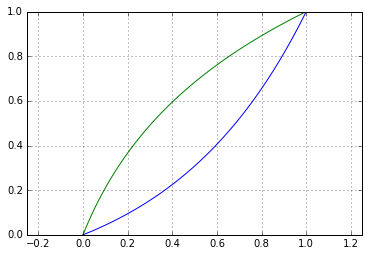

In [80]:
alpha = 11
yorig = np.linspace(0.00,1,100)

y2 = [(math.log(alpha*Y + math.e) - 1.)*(1./(math.log(alpha + math.e) - 1)) for Y in yorig ]
y3 = [(math.e**(Y*(math.log(alpha + math.e) - 1) + 1 ) - math.e)/alpha for Y in yorig ]
pyplot.plot(yorig, y3)
pyplot.plot(yorig, y2)
pyplot.axis('equal')
pyplot.grid()

In [3]:
alpha = 11.
res = 256
dyo = 1./res

dyn = 1. - (math.log(alpha*(1- dyo ) + math.e) - 1.)*(1./(math.log(alpha + math.e) - 1))

print(dyo, dyn, (dyo/dyn))

(0.00390625, 0.001938026862393638, 2.015580937394969)


In [4]:
### print((math.log(alpha*0. + math.e) - 1)*(1/(math.log(alpha + math.e) - 1)), (math.log(alpha*1. + math.e) - 1)*(1/(math.log(alpha + math.e) - 1)))
print((math.e**(0*(math.log(alpha + math.e) - 1) + 1 ) - math.e)/alpha, (math.e**(1.*(math.log(alpha + math.e) - 1) + 1 ) - math.e)/alpha)

#(math.e**(0.*math.log(alpha + math.e)) - math.e)/alpha

(0.0, 0.9999999999999999)


In [9]:
# RT PIC - classic and nearest neighbour
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os
#from shapely.geometry import Polygon
#from shapely.geometry import Point

In [10]:
dim = 2

meshX = 64
meshY = 64

In [11]:
# create mesh objects
elementMesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0', 
                                         elementRes=(meshX, meshY), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,1.0))
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

In [44]:
# create fevariables
velocityField    = uw.mesh.MeshVariable( mesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.mesh.MeshVariable( mesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.mesh.MeshVariable( mesh=linearMesh,   nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=linearMesh,         nodeDofCount=1 )


In [45]:
for index, coord in enumerate(linearMesh.data):
    if coord[1] < 0.7:
        temperatureField.data[index] = 0.5  
    else:
        temperatureField.data[index] = 1. - coord[1]
    

In [46]:
#(math.log(0 + 0.001)/alpha + 1) + abs((math.log(0.0 + 0.001)/alpha + 1))

In [47]:
#THis one for the rectangonal mesh
alpha = 1.
newys = []
newxs = []
for index, coord in enumerate(linearMesh.data):
    y0 = coord[1]
    x0 = abs(coord[0])
    newy = (math.log(alpha*y0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
    if coord[0] > 0:
        newx = (math.e**(x0*(math.log((alpha/2.) + math.e) - 1) + 1 ) - math.e)/(alpha/2.)     
    else:
        newx = -1.*(math.e**(x0*(math.log((alpha/2.) + math.e) - 1) + 1 ) - math.e)/(alpha/2.)
    newys.append(newy)
    newxs.append(newx)
    #print y0,newy

In [48]:
#THis one for the square mesh

alpha = 11.
newys = []
newxs = []
for index, coord in enumerate(linearMesh.data):
    y0 = coord[1]
    x0 = abs(coord[0])
    newy = (math.log(alpha*y0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
    newx = (math.log(alpha*x0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
    newys.append(newy)
    newxs.append(newx)

In [49]:
linearMesh.data[:,1]

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [50]:
with linearMesh.deform_mesh():
    linearMesh.data[:,1] = newys
    linearMesh.data[:,0] = newxs


In [51]:

    
#figtemp = plt.Figure()
#figtemp.Surface(temperatureField, elementMesh)
#figtemp.Surface(indexField, elementMesh)
#figtemp.Mesh(linearMesh, colourBar=False)
#figtemp.show()


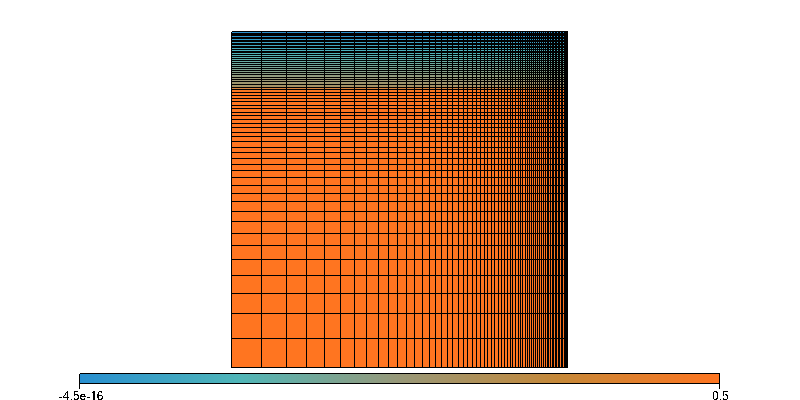

In [52]:

# gLucifer visualisation of mesh
fig = glucifer.Figure( figsize=(800,400) )
fig.append(glucifer.objects.Mesh( elementMesh ))
fig.append(glucifer.objects.Surface( elementMesh, temperatureField))
fig.show()

In [53]:
#indexField = uw.fevariable.FeVariable( feMesh=linearMesh, nodeDofCount=1)

#for index, coord in enumerate(linearMesh.data):
#     indexField.data[index] = ((index % (meshX+1)) % 2 ==0)
#    indexField.data[index] = ((index/(meshX+1) % (meshY+1)) % 2 ==0)


#figindex = plt.Figure()
#figindex.Surface(indexField, elementMesh)
#figindex.Mesh(linearMesh, colourBar=False)
#figindex.show()

In [54]:
#indexField.evaluate((0.5,0.26))

In [55]:
#linearMesh._cself.isRegular#

In [56]:
Ra=1.e6
rho = 4.0e3
grav = 10
height = 1.e6
kappa = 1.0e-6

# Set a constant viscosity.
viscosity = 1.

# Create our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# A buoyancy function.
buoyancyFn = densityFn * z_hat

# The temperature gradient is useful in the analysis below. We access it via the 'gradientFn' attribute provided
# via the FeVariable.
gradField = temperatureField.fn_gradient

In [57]:
iWalls = elementMesh.specialSets["MinI_VertexSet"] + elementMesh.specialSets["MaxI_VertexSet"]
jWalls = elementMesh.specialSets["MinJ_VertexSet"] + elementMesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition(     variable = velocityField, 
                                              indexSetsPerDof = (iWalls,jWalls) )
tempBC     = uw.conditions.DirichletCondition(     variable = temperatureField, 
                                              indexSetsPerDof = (jWalls,) )

In [58]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               fn_viscosity   = viscosity, 
                               fn_bodyforce   = buoyancyFn )

In [61]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField,velocityField, fn_diffusivity=1., conditions=[tempBC,], )

In [64]:
solver = uw.systems.Solver(stokesPIC)
solver.solve() 



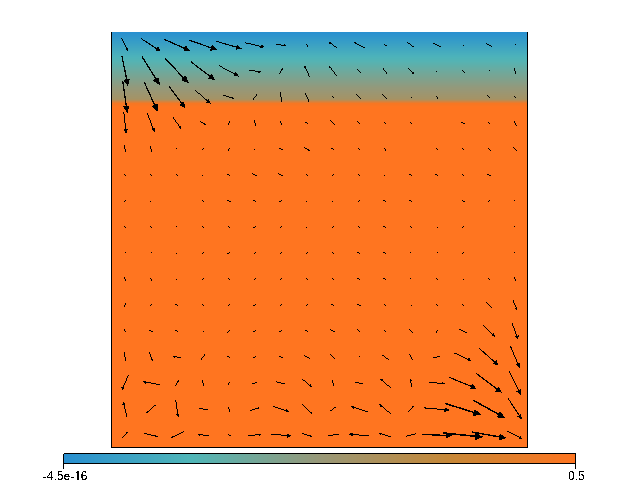

In [67]:

velmax = np.amax(velocityField.data[:])
if(velmax==0.0): velmax = 1.0
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.Surface(linearMesh, temperatureField) )
fig1.append( glucifer.objects.VectorArrows(linearMesh, velocityField/velmax, scaling=0.1, arrowHead=0.2) )
fig1.show()

## Example 2: 

This refinement function is given in the Fenics documentation: http://fenicsproject.org/documentation/tutorial/prepro.html

$y' = a + (b-a)(\frac{y-a}{b-a})^s$

Here I'm using the similar expression:

$y' = 1. - \left( a + (b-a)(\frac{y-a}{b-a})^s \right)$

(0.0, 1.0, 0.0, 1.0)

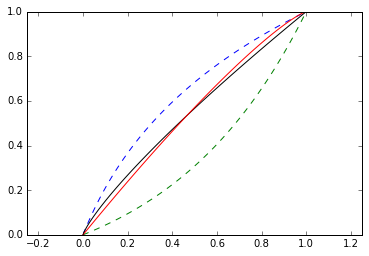

In [192]:
s = 1.22
a = 0.00
b = 1.
yorig = np.linspace(a,b,100)

yp0 = [a + (b-a)*((Y - a)/(b-a))**(1./s) for Y in yorig ]
yp1 = [1. - (a + (b-a)*((1 - Y)/(b-a))**s) for Y in yorig ]


pyplot.plot(yorig, y2, linestyle='--')
pyplot.plot(yorig, y3, linestyle='--')


pyplot.plot(yorig, yp0, c= 'k')
pyplot.plot(yorig, yp1)
#pyplot.grid()
pyplot.axis('equal')


In [193]:
max(yp1)

1.0

In [211]:
s = 1.26
a = 0.00
b = 1.

# create mesh objects
elementMesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0', 
                                         elementRes=(meshX, meshY), 
                                           minCoord=(a,a), 
                                           maxCoord=(b,b))
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

In [212]:
# create fevariables
velocityField    = uw.mesh.MeshVariable( mesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.mesh.MeshVariable( mesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.mesh.MeshVariable( mesh=linearMesh,   nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=linearMesh,         nodeDofCount=1 )

In [213]:
for index, coord in enumerate(linearMesh.data):
    if coord[1] < 0.7:
        temperatureField.data[index] = 0.5  
    else:
        temperatureField.data[index] = 1. - coord[1]
    

In [214]:
#THis one for the square mesh


newys = []
newxs = []
for index, coord in enumerate(linearMesh.data):
    y0 = coord[1]
    x0 = abs(coord[0])
    newy =(1. - (a + (b-a)*((1 - y0)/(b-a))**s))
    newx =(1. - (a + (b-a)*((1 - x0)/(b-a))**s)) 
    newys.append(newy)
    newxs.append(newx)

In [215]:
with linearMesh.deform_mesh():
    linearMesh.data[:,1] = newys
    linearMesh.data[:,0] = newxs

In [216]:


# gLucifer visualisation of mesh
fig = glucifer.Figure( figsize=(800,400) )
fig.append(glucifer.objects.Mesh( elementMesh ))
fig.append(glucifer.objects.Surface( elementMesh, temperatureField))
fig.show()
fig.save_database('test.gldb')

In [200]:
s

1.5

In [209]:
s = 1.22 
res = 64.
dy = 1/res
dyp =(1. - (a + (b-a)*((1 - (1 - dy)/(b-a))**s)))
#print(dyp)
print((dy)/(1-dyp))

2.4966610978


In [210]:
for i in np.arange(1,1.3,0.02):
    dyp =(1. - (a + (b-a)*((1 - (1 - dy)/(b-a))**i)))
    #print(dyp)
    print("s is: " + str(i) + " del y is: " + str((dy)/(1-dyp)))

s is: 1.0 del y is: 1.0
s is: 1.02 del y is: 1.08673486253
s is: 1.04 del y is: 1.18099266143
s is: 1.06 del y is: 1.28342589756
s is: 1.08 del y is: 1.39474366635
s is: 1.1 del y is: 1.51571656651
s is: 1.12 del y is: 1.64718203454
s is: 1.14 del y is: 1.79005014186
s is: 1.16 del y is: 1.94530989482
s is: 1.18 del y is: 2.11403608112
s is: 1.2 del y is: 2.29739670999
s is: 1.22 del y is: 2.4966610978
s is: 1.24 del y is: 2.7132086549
s is: 1.26 del y is: 2.94853843458
s is: 1.28 del y is: 3.20427951036
s is: 1.3 del y is: 3.48220225318


In [172]:
range?

In [174]:
list(range(0, -10, -1))

[0, -1, -2, -3, -4, -5, -6, -7, -8, -9]